# IMDB dataset을 이용한 text classification

- forked from https://github.com/tensorflow/docs/blob/master/site/ko/tutorials/keras/text_classification.ipynb   


이번 실습에서는 IMDB(Internet Movie DataBase) dataset을 이용하여,   
영화평에 대한 긍정/부정의 sentimental anaylsis classification을 학습해봅니다.

이 노트북은 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 이진(binary)-또는 클래스(class)가 두 개인- 분류 문제입니다. 이진 분류는 머신러닝에서 중요하고 널리 사용됩니다.

여기에서는 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용하겠습니다. 25,000개 리뷰는 훈련용으로, 25,000개는 테스트용으로 나뉘어져 있습니다. 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
## library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.1.0-rc1
2.2.4-tf


## Preparing Data

In [0]:
'''
imdb data를 loading합니다
num_words=vocab_size는 imdb data에서 가장 많이 등장하는 10000개의 단어만 선택하고,
나머지는 unknown 처리하게 합니다
'''

vocab_size = 10000
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

In [0]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


In [0]:
## 첫번째 data가 어떻게 구성되어 있는지 확인
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [0]:
## 첫번째, 두번째 data의 단어 수 확인 - 각 data마다 단어 수가 다른 것을 알 수 있습니다
len(train_data[0]), len(train_data[1])

(218, 189)

In [0]:
## 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

## 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

## 정수를 입력받아서 text를 출력해주는 함수
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
## 첫번째 data를 text로 바꾸어 출력
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
train_labels[0]

1

In [0]:
## 문장의 최대 단어수 지정
maxlen = 500

## RNN에 넣기 위하여 모든 문장을 최대 단어수로 맞춰줍니다
## 이 때 pad_sequence를 사용하여 문장의 뒷부분에 0(<PAD>)을 채우는 방식으로 padding을 해줍니다
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

In [0]:
## padding이 잘 되었는지 확인
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Model

In [0]:
## word embedding에서 사용할 word vector의 크기를 지정
embedding_dim=16

## Model 만들기
## 여기서 CNN의 channel역할을 하는 것이 위에서 설정한 word vector의 크기입니다
## 즉 golbal average pooling을 하면 batch_size, channel의 2차원의 output이 나옵니다
model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Model Compile

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Splitting Train/Validation data

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Training

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 3s 202us/sample - loss: 0.6924 - accuracy: 0.5237 - val_loss: 0.6915 - val_accuracy: 0.5433
Epoch 2/40
15000/15000 [==============================] - 1s 49us/sample - loss: 0.6895 - accuracy: 0.5929 - val_loss: 0.6875 - val_accuracy: 0.5748
Epoch 3/40
15000/15000 [==============================] - 1s 48us/sample - loss: 0.6828 - accuracy: 0.6211 - val_loss: 0.6784 - val_accuracy: 0.7150
Epoch 4/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6700 - accuracy: 0.7407 - val_loss: 0.6627 - val_accuracy: 0.7619
Epoch 5/40
15000/15000 [==============================] - 1s 46us/sample - loss: 0.6488 - accuracy: 0.7660 - val_loss: 0.6391 - val_accuracy: 0.7729
Epoch 6/40
15000/15000 [==============================] - 1s 47us/sample - loss: 0.6197 - accuracy: 0.7870 - val_loss: 0.6090 - val_accuracy: 0.7853
Epoch 7/40
15000/15000 [==============================]

## Checking the Test Result

In [0]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 2s 78us/sample - loss: 0.3128 - accuracy: 0.8788
[0.3127590613889694, 0.87884]


## Plotting Training Curves

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

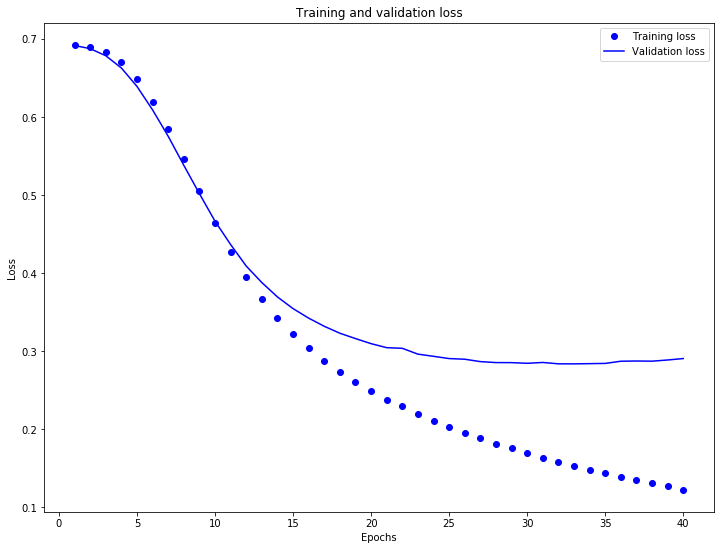

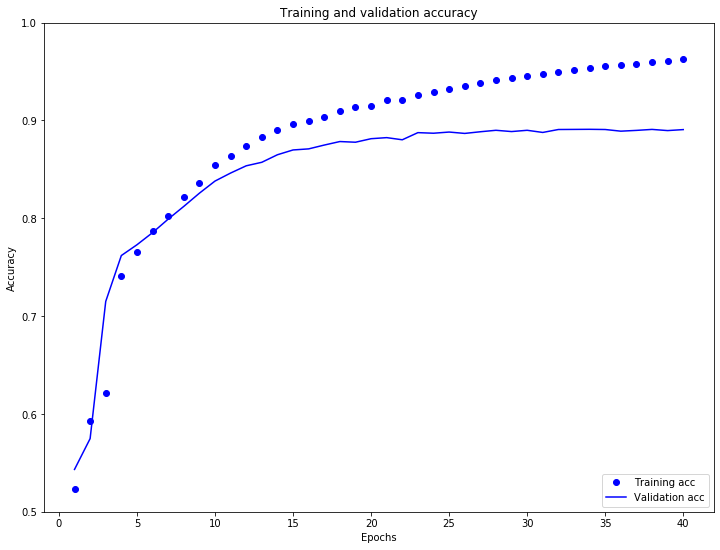

In [0]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()